# Introduction

### Main goal¶
The main goal of this project is to explore CNN architecture, compare it with Fully Connected NN and estimate their accuracy and efficiency for the standard MNIST dataset. The secondary goal is to take part in the competition.
It is part of my studying of Machine learning through the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning).

## Data
From [Digit Recognizer Dataset](https://www.kaggle.com/c/digit-recognizer/data) Description:
>The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
>Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
>The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
>Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

### Plan
1. Load and explore data and needed libs
2. Data preparation
    * Scale
    * Reshape
    * Encode labels
    * Split into training and validation set
    * Add Data Augmentation to avoid overfitting
3. Work
    * Fully Connected NN
    * Convolutional NN (experiment with 2 different architectures)
4. Conclusions
    * Key Findings
    * Suggestions for next steps
    
### References
1. [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) by YASSINE GHOUZAM
2. [MNIST with Keras for Beginners(.99457)](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457) by ADITYA SONI
3. [Digit recognizer with Keras](https://www.kaggle.com/code/dariasvasileva/digit-recognizer-with-keras) by DARIA VASILEVA
4. [Convolutional Neural Network (CNN) Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial) by DATAI

In [1]:
# core libs
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import seaborn as sns
# %matplotlib inline

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# keras
from keras.utils.np_utils import to_categorical
from keras.utils.layer_utils import count_params
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, Callback

#tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# to compare the computation time between models
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
# reference https://www.kaggle.com/code/dariasvasileva/digit-recognizer-with-keras

In [3]:
# loading data sets
df_train = pd.read_csv("../input/digit-recognizer/train.csv")
df_test = pd.read_csv("../input/digit-recognizer/test.csv")

In [4]:
# data shape
print("Train data size: ", df_train.shape)
print("Test data size: ", df_test.shape)
print('-'*60)

# check for NAs
print('NAs in train set: ', df_train.isnull().sum().sum())
print('NAs in test set: ', df_test.isnull().sum().sum())
print('-'*60)

df_train.head()

Train data size:  (42000, 785)
Test data size:  (28000, 784)
------------------------------------------------------------
NAs in train set:  0
NAs in test set:  0
------------------------------------------------------------


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# define target and features
y_train = df_train['label'].copy()

X_train = df_train.drop(columns = 'label').copy()
X_test = df_test.copy() # no labels here

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (42000, 784)
X_test shape:  (28000, 784)
y_train shape:  (42000,)


In [6]:
# look at the distribution of labels in the train dataset
y_train.value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

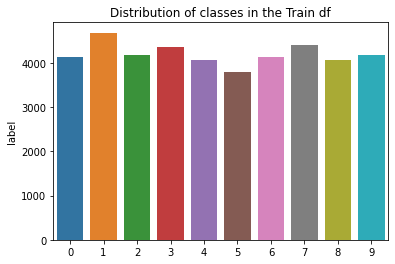

In [7]:
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts())
plt.title('Distribution of classes in the Train df')
plt.show()

All 10 classes are represented in the train dataset approx. equally: about 10% or 4000 enteries of each.

In [8]:
# scale values
X_train = X_train / 255.0
X_test = X_test / 255.0

# check scaling
print('X_train maximum value: ', X_train.values.max())
print('X_train minimum value: ', X_train.values.min())
print('-' * 60)
print('X_test maximum value: ', X_test.values.max())
print('X_test minimum value: ', X_test.values.min())
print('-' * 60)
print('-' * 60)

# reshape
X_train = X_train.values.reshape((X_train.shape[0],) + (28, 28, 1))
X_test = X_test.values.reshape((X_test.shape[0],) + (28, 28, 1))

# check new shapes
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train maximum value:  1.0
X_train minimum value:  0.0
------------------------------------------------------------
X_test maximum value:  1.0
X_test minimum value:  0.0
------------------------------------------------------------
------------------------------------------------------------
X_train shape:  (42000, 28, 28, 1)
X_test shape:  (28000, 28, 28, 1)


In [9]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes = 10)
print('y_train shape: ', y_train.shape)
y_train[0:5]

y_train shape:  (42000, 10)


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

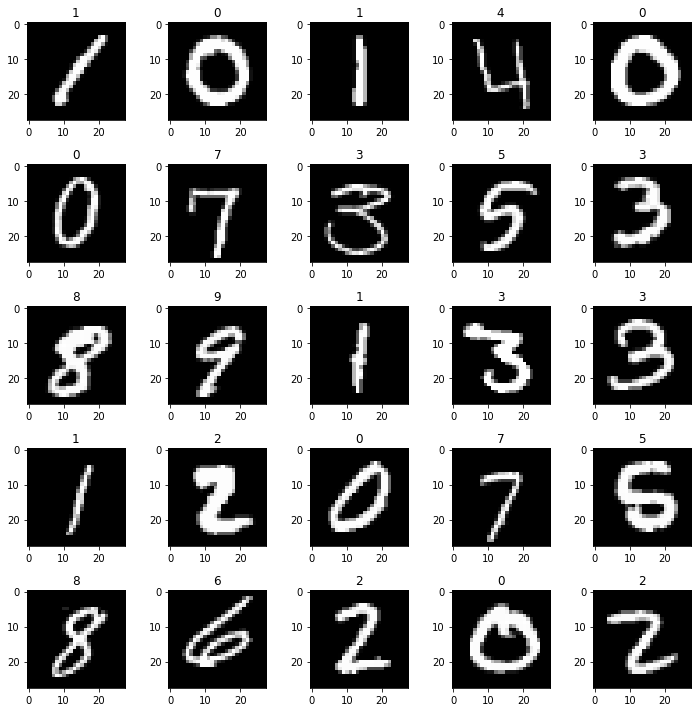

In [10]:
# visualize images with labels
fig, axList = plt.subplots(5, 5, sharex=False, sharey=False)
axList = axList.flatten()
fig.set_size_inches(10, 10)

for i,ax in enumerate(axList):
    ax.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    ax.set_title(np.argmax(y_train[i]))
            
fig.tight_layout()
fig.show()

In [11]:
# split train data into the train and the validation set for the fitting
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.1, random_state = 43)

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_validation.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_validation.shape)

X_train shape:  (37800, 28, 28, 1)
X_val shape:  (4200, 28, 28, 1)
y_train shape:  (37800, 10)
y_val shape:  (4200, 10)


In [12]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

datagen.fit(X_train)

# source: https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial

# Work
## Fully Connected Neural Network

Ordinary Fully Connected NN
    
Architecture:
* Flatten
* Dense 1 (512 units, 'relu')
* Dropout (0.4)
* Dense 2 (256 units, 'relu')
* Dropout (0.5)
* Dense - output (10 units, 'softmax')

In [13]:
# build and compile model
model_fcnn = Sequential([
                        Flatten(input_shape = (28,28,1)),
                        Dense(512, activation='relu'),
                        Dropout(0.4),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(10, activation='softmax')
])

model_fcnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

2023-01-11 15:03:40.430782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:03:40.519861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:03:40.521694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:03:40.523794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
# model summary
model_fcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
__________________________________________________

In [15]:
# set up fitting parameters

# optimizer
optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# epochs and batch size
epochs = 20 
batch_size = 250

# define learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.0001)

In [16]:
# fit the model
time_callback = TimeHistory()
fcnn_history1 = model_fcnn.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                               epochs = epochs, validation_data = (X_validation, y_validation),
                               verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size, 
                               callbacks = [learning_rate_reduction, time_callback]
                              )
times = time_callback.times

2023-01-11 15:03:43.230669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
151/151 [==============================] - 11s 63ms/step - loss: 0.9972 - accuracy: 0.6725 - val_loss: 0.2326 - val_accuracy: 0.9343
Epoch 2/20
151/151 [==============================] - 9s 60ms/step - loss: 0.4436 - accuracy: 0.8658 - val_loss: 0.1424 - val_accuracy: 0.9605
Epoch 3/20
151/151 [==============================] - 8s 54ms/step - loss: 0.3294 - accuracy: 0.8996 - val_loss: 0.1135 - val_accuracy: 0.9643
Epoch 4/20
151/151 [==============================] - 10s 65ms/step - loss: 0.2876 - accuracy: 0.9115 - val_loss: 0.0992 - val_accuracy: 0.9698
Epoch 5/20
151/151 [==============================] - 10s 63ms/step - loss: 0.2555 - accuracy: 0.9227 - val_loss: 0.0863 - val_accuracy: 0.9738
Epoch 6/20
151/151 [==============================] - 9s 58ms/step - loss: 0.2333 - accuracy: 0.9296 - val_loss: 0.0820 - val_accuracy: 0.9764
Epoch 7/20
151/151 [==============================] - 9s 57ms/step - loss: 0.2238 - accuracy: 0.9323 - val_loss: 0.0780 - val_accuracy: 0.9

Text(0.5, 0.98, 'Fully Connected Neural Network')

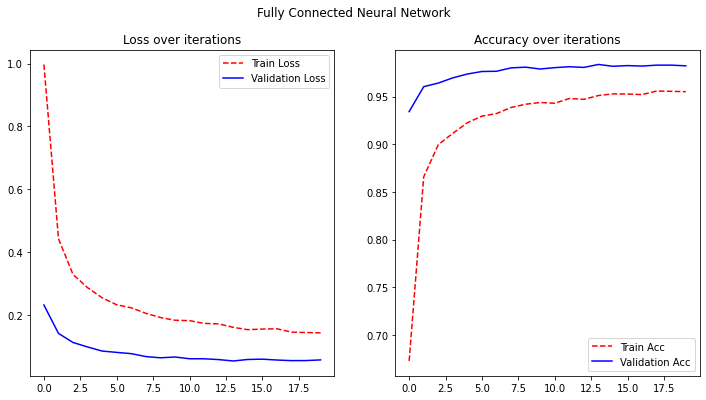

In [17]:
# plot Loss and Accuracy
n = len(fcnn_history1.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (fcnn_history1.history["loss"]),'r--', label="Train Loss")
ax.plot(range(n), (fcnn_history1.history["val_loss"]),'b-', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (fcnn_history1.history["accuracy"]),'r--', label="Train Acc")
ax.plot(range(n), (fcnn_history1.history["val_accuracy"]),'b-', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

fig.suptitle('Fully Connected Neural Network')

In [18]:
score = model_fcnn.evaluate(X_validation, y_validation, verbose=0)
print('Test score:', round(score[0], 4))
print('Test accuracy:', round(score[1], 4))

Test score: 0.0582
Test accuracy: 0.9824


In [19]:
# fit the model again to see if score will improve
fcnn_history2 = model_fcnn.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                               epochs = 10, validation_data = (X_validation, y_validation),
                               verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size, 
                               callbacks = [learning_rate_reduction, time_callback])

Epoch 1/10
151/151 [==============================] - 9s 56ms/step - loss: 0.1413 - accuracy: 0.9562 - val_loss: 0.0542 - val_accuracy: 0.9838
Epoch 2/10
151/151 [==============================] - 9s 58ms/step - loss: 0.1407 - accuracy: 0.9568 - val_loss: 0.0561 - val_accuracy: 0.9819
Epoch 3/10
151/151 [==============================] - 8s 55ms/step - loss: 0.1402 - accuracy: 0.9574 - val_loss: 0.0532 - val_accuracy: 0.9833
Epoch 4/10
151/151 [==============================] - 9s 57ms/step - loss: 0.1333 - accuracy: 0.9587 - val_loss: 0.0606 - val_accuracy: 0.9824
Epoch 5/10
151/151 [==============================] - 9s 60ms/step - loss: 0.1370 - accuracy: 0.9579 - val_loss: 0.0501 - val_accuracy: 0.9850
Epoch 6/10
151/151 [==============================] - 9s 56ms/step - loss: 0.1347 - accuracy: 0.9589 - val_loss: 0.0575 - val_accuracy: 0.9814
Epoch 7/10
151/151 [==============================] - 9s 57ms/step - loss: 0.1329 - accuracy: 0.9590 - val_loss: 0.0492 - val_accuracy: 0.9855

Text(0.5, 1.0, 'Loss Values for Fully Connected Neural Network')

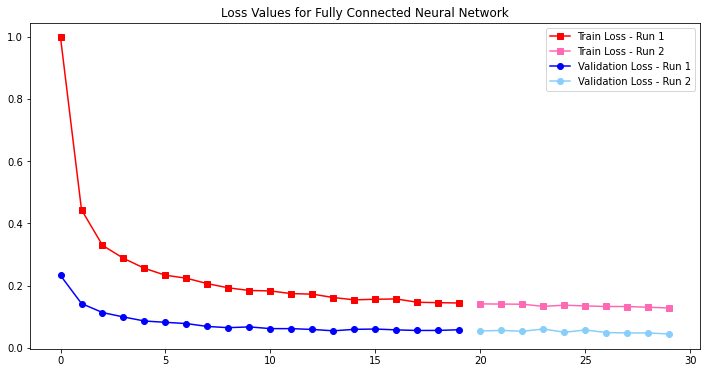

In [20]:
n = len(fcnn_history1.history["loss"])
m = len(fcnn_history2.history['loss'])
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(n), fcnn_history1.history["loss"],'r', marker='s', label="Train Loss - Run 1")
ax.plot(range(n, n+m), fcnn_history2.history["loss"], 'hotpink', marker='s', label="Train Loss - Run 2")

ax.plot(range(n), fcnn_history1.history["val_loss"],'b', marker='o', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), fcnn_history2.history["val_loss"], 'LightSkyBlue', marker='o',  label="Validation Loss - Run 2")

ax.legend()
ax.set_title("Loss Values for Fully Connected Neural Network")

In [21]:
score = model_fcnn.evaluate(X_validation, y_validation, verbose=0)
scores = pd.DataFrame(data = {'model': ['Fully Connected NN'],  
                              'test score': [round(score[0], 4)], 
                              'test accuracy': [round(score[1], 4)],
                              'sec per epoch': [round(sum(times)/len(times), 2)],
                              'trainable weights': [count_params(model_fcnn.trainable_weights)]})
scores

,model,test score,test accuracy,sec per epoch,trainable weights
0,Fully Connected NN,0.0446,0.9871,8.89,535818


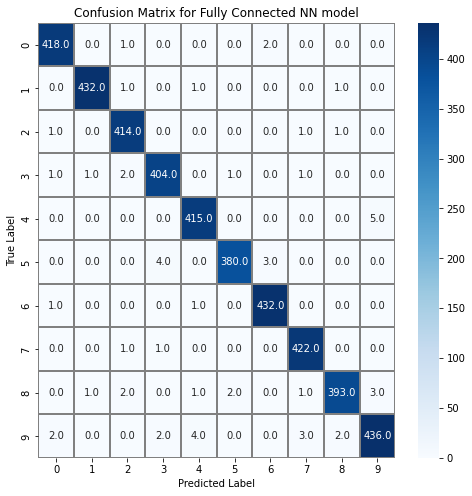

In [22]:
# confusion matrix

# predict values (probabilities)
y_pred = model_fcnn.predict(X_validation)
# predict classes
y_pred_classes = np.argmax(y_pred, axis = 1)
# convert true classes to one vector with 10 categories
y_true = np.argmax(y_validation, axis = 1) 

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

# plot confusion matrix
fig,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(cm, annot = True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Fully Connected NN model")
plt.show()

## Convolutional Neural Networks
To design CNNs for this project I used the following principles:

1. I used only 3x3 convolutions, but applied 2 Convolutional layers in a row. It is a "cell".
2. Each "convolutional cell" consist of:
    * 2 convolutional layers with {n} feature maps using 3x3 filter and stride 1 ({n}C3);
    * 1 pooling layer using 2x2 filter and stride 2 (P2);
    * 1 dropout layer (Dp).
3. I experimented with the number of cells in my CNN:
    * 1-cell CNN:   
    (28x28x1) -> **[32C3 - 32C2 - P2 - Dp]** -> (14x14x32) -> **Flatten** -> **Dense(512, relu)** -> **Dp** -> **Dense(10, softmax)**  
    * 2-cell CNN:   
    (28x28x1) -> **[32C3 - 32C2 - P2 - Dp]** -> (14x14x32) -> **[64C3 - 64C2 - P2 - Dp]** -> (7x7x64) -> **Flatten** -> **Dense(512, relu)** -> **Dp** -> **Dense(10, softmax)**
        
### 1-cell  CNN

In [23]:
# build and compile model
model_1c_cnn = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)),
    Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'softmax')
])

model_1c_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
# model summary
model_1c_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               3211776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [25]:
# fit the model
time_callback = TimeHistory()
cnn_1c_history = model_1c_cnn.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                               epochs = epochs, validation_data = (X_validation, y_validation),
                               verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size, 
                               callbacks = [learning_rate_reduction, time_callback])
times = time_callback.times

Epoch 1/20


2023-01-11 15:08:29.868609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


151/151 [==============================] - 15s 64ms/step - loss: 0.6419 - accuracy: 0.7935 - val_loss: 0.0942 - val_accuracy: 0.9726
Epoch 2/20
151/151 [==============================] - 9s 59ms/step - loss: 0.2008 - accuracy: 0.9383 - val_loss: 0.0583 - val_accuracy: 0.9838
Epoch 3/20
151/151 [==============================] - 9s 60ms/step - loss: 0.1464 - accuracy: 0.9561 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 4/20
151/151 [==============================] - 9s 61ms/step - loss: 0.1188 - accuracy: 0.9640 - val_loss: 0.0430 - val_accuracy: 0.9857
Epoch 5/20
151/151 [==============================] - 9s 59ms/step - loss: 0.1043 - accuracy: 0.9682 - val_loss: 0.0372 - val_accuracy: 0.9876
Epoch 6/20
151/151 [==============================] - 9s 61ms/step - loss: 0.0958 - accuracy: 0.9696 - val_loss: 0.0355 - val_accuracy: 0.9886
Epoch 7/20
151/151 [==============================] - 9s 62ms/step - loss: 0.0880 - accuracy: 0.9730 - val_loss: 0.0340 - val_accuracy: 0.9895
Epoch 8/2

Text(0.5, 0.98, 'CNN model with 1 cell')

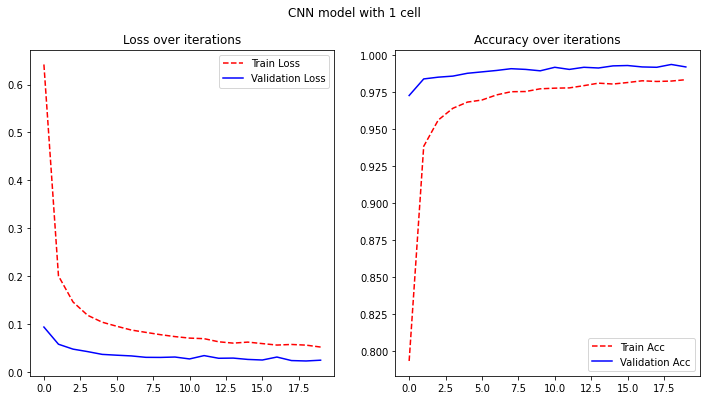

In [26]:
# plot Loss and Accuracy
n = len(cnn_1c_history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (cnn_1c_history.history["loss"]),'r--', label="Train Loss")
ax.plot(range(n), (cnn_1c_history.history["val_loss"]),'b-', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (cnn_1c_history.history["accuracy"]),'r--', label="Train Acc")
ax.plot(range(n), (cnn_1c_history.history["val_accuracy"]),'b-', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

fig.suptitle('CNN model with 1 cell')

In [27]:
score = model_1c_cnn.evaluate(X_validation, y_validation, verbose=0)
scores = scores.append({'model': '1-cell CNN', 
                        'test score': round(score[0], 4), 
                        'test accuracy': round(score[1], 4),
                        'sec per epoch': round(sum(times)/len(times), 2),
                        'trainable weights': count_params(model_1c_cnn.trainable_weights)}, 
                        ignore_index=True)
scores

,model,test score,test accuracy,sec per epoch,trainable weights
0,Fully Connected NN,0.0446,0.9871,8.89,535818
1,1-cell CNN,0.0251,0.9919,9.43,3226474


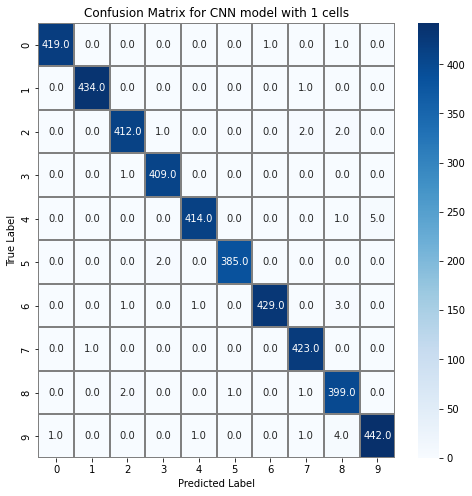

In [28]:
# confusion matrix

# predict values (probabilities)
y_pred = model_1c_cnn.predict(X_validation)
# predict classes
y_pred_classes = np.argmax(y_pred, axis = 1)
# convert true classes to one vector with 10 categories
y_true = np.argmax(y_validation, axis = 1) 

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

# plot confusion matrix
fig,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(cm, annot = True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN model with 1 cells")
plt.show()

### 2-cell CNN

In [29]:
# build and compile model
model_2c_cnn = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)),
    Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    Dropout(0.4),
    
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'softmax')
])

model_2c_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
# model summary
model_2c_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [31]:
# fit the model
time_callback = TimeHistory()
cnn_2c_history = model_2c_cnn.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                               epochs = epochs, validation_data = (X_validation, y_validation),
                               verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size, 
                               callbacks = [learning_rate_reduction, time_callback])
times = time_callback.times

Epoch 1/20
151/151 [==============================] - 10s 61ms/step - loss: 0.6002 - accuracy: 0.7999 - val_loss: 0.0774 - val_accuracy: 0.9767
Epoch 2/20
151/151 [==============================] - 9s 61ms/step - loss: 0.1755 - accuracy: 0.9462 - val_loss: 0.0528 - val_accuracy: 0.9831
Epoch 3/20
151/151 [==============================] - 10s 66ms/step - loss: 0.1214 - accuracy: 0.9622 - val_loss: 0.0486 - val_accuracy: 0.9848
Epoch 4/20
151/151 [==============================] - 9s 62ms/step - loss: 0.1002 - accuracy: 0.9691 - val_loss: 0.0328 - val_accuracy: 0.9898
Epoch 5/20
151/151 [==============================] - 9s 58ms/step - loss: 0.0866 - accuracy: 0.9742 - val_loss: 0.0317 - val_accuracy: 0.9900
Epoch 6/20
151/151 [==============================] - 10s 63ms/step - loss: 0.0791 - accuracy: 0.9759 - val_loss: 0.0284 - val_accuracy: 0.9917
Epoch 7/20
151/151 [==============================] - 9s 62ms/step - loss: 0.0678 - accuracy: 0.9794 - val_loss: 0.0277 - val_accuracy: 0.9

Text(0.5, 0.98, 'CNN model with 2 cells')

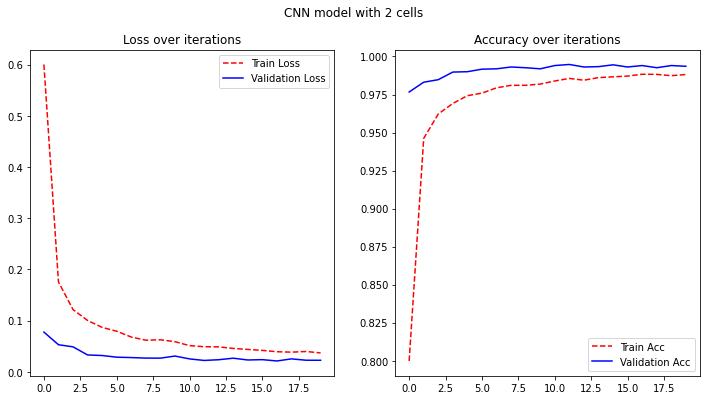

In [32]:
# plot Loss and Accuracy
n = len(cnn_2c_history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (cnn_2c_history.history["loss"]),'r--', label="Train Loss")
ax.plot(range(n), (cnn_2c_history.history["val_loss"]),'b-', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (cnn_2c_history.history["accuracy"]),'r--', label="Train Acc")
ax.plot(range(n), (cnn_2c_history.history["val_accuracy"]),'b-', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

fig.suptitle('CNN model with 2 cells')

In [33]:
score = model_2c_cnn.evaluate(X_validation, y_validation, verbose=0)
scores = scores.append({'model': '2-cell CNN', 
                        'test score': round(score[0], 4), 
                        'test accuracy': round(score[1], 4),
                        'sec per epoch': round(sum(times)/len(times), 2),
                        'trainable weights': count_params(model_2c_cnn.trainable_weights)}, 
                        ignore_index=True)
scores

,model,test score,test accuracy,sec per epoch,trainable weights
0,Fully Connected NN,0.0446,0.9871,8.89,535818
1,1-cell CNN,0.0251,0.9919,9.43,3226474
2,2-cell CNN,0.0224,0.9936,9.32,1676266


Any other architecture that I tested does not improve the situation significantly.

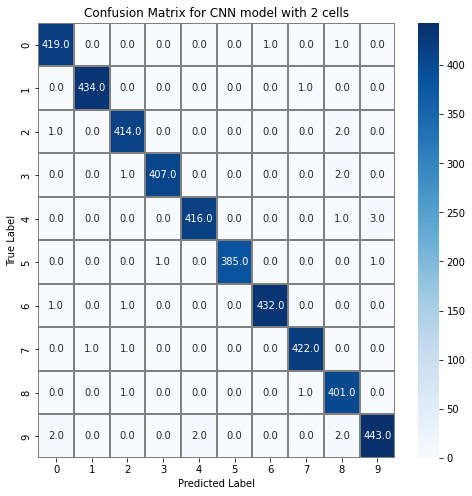

In [34]:
# confusion matrix

# predict values (probabilities)
y_pred = model_2c_cnn.predict(X_validation)
# predict classes
y_pred_classes = np.argmax(y_pred, axis = 1)
# convert true classes to one vector with 10 categories
y_true = np.argmax(y_validation, axis = 1) 

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

# plot confusion matrix
fig,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(cm, annot = True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN model with 2 cells")
plt.show()

### Submision

In [35]:
# perform prediction on the test set


results = model_2c_cnn.predict(X_test)
results = np.argmax(results, axis = 1)

# create submission files

submission = pd.DataFrame({'ImageId': list(range(1,len(results)+1)), 'Label': results})
submission.to_csv('submission.csv', index=False)

# Conclusions

## Key Findings 
1. The Fully Connected NN model performed worse than any CNN model, as expected.
2. The number of "convolutional cells" didn't seem to affect the performance of CNN models much for this MNIST dataset. 
 

## Submision
The best result is 0.9935 (V4). It is a TOP 19%.

## Nest Steps
Try to adjust the CNN model architecture or try something another. 